<a href="https://colab.research.google.com/github/rolandoteniya/architectural-style-cnn-classification/blob/main/Architectural_CNN_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# University of Liverpool

## COMP634 - Applied AI

---

### Student ID(s): 201884707, 201874468, 201422688, 201912133
### Assignment 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. **Data Management**

In this section:
1. Define experimental protocol (train/val/test split)
2. Create dataloaders with normalization and data augmentation

In [ ]:
import os
import json
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import seaborn as sns
import warnings

from PIL import Image
from pathlib import Path
from collections import Counter, defaultdict
from torch.utils.data import DataLoader, Dataset, random_split, SubsetRandomSampler, WeightedRandomSampler
from torchvision import transforms, models, datasets
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from tqdm import tqdm

warnings.filterwarnings('ignore')


# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

SEED = 42
data_path = Path("/content/drive/MyDrive/Applied AI Labs/ASSIGNMENT 2/assignment2_dataset/dataset")
split_path = Path("/content/drive/MyDrive/Applied AI Labs/ASSIGNMENT 2/assignment2_dataset/split")

Using device: cpu


Found 11534 images across 10 classes.
Classes: ['altar', 'apse', 'bell_tower', 'column', 'dome(inner)', 'dome(outer)', 'flying_buttress', 'gargoyle', 'stained_glass', 'vault']


altar                -> 968 images
apse                 -> 555 images
bell_tower           -> 1227 images
column               -> 2124 images
dome(inner)          -> 658 images
dome(outer)          -> 1317 images
flying_buttress      -> 475 images
gargoyle             -> 1802 images
stained_glass        -> 1148 images
vault                -> 1260 images

All files are in .jpg


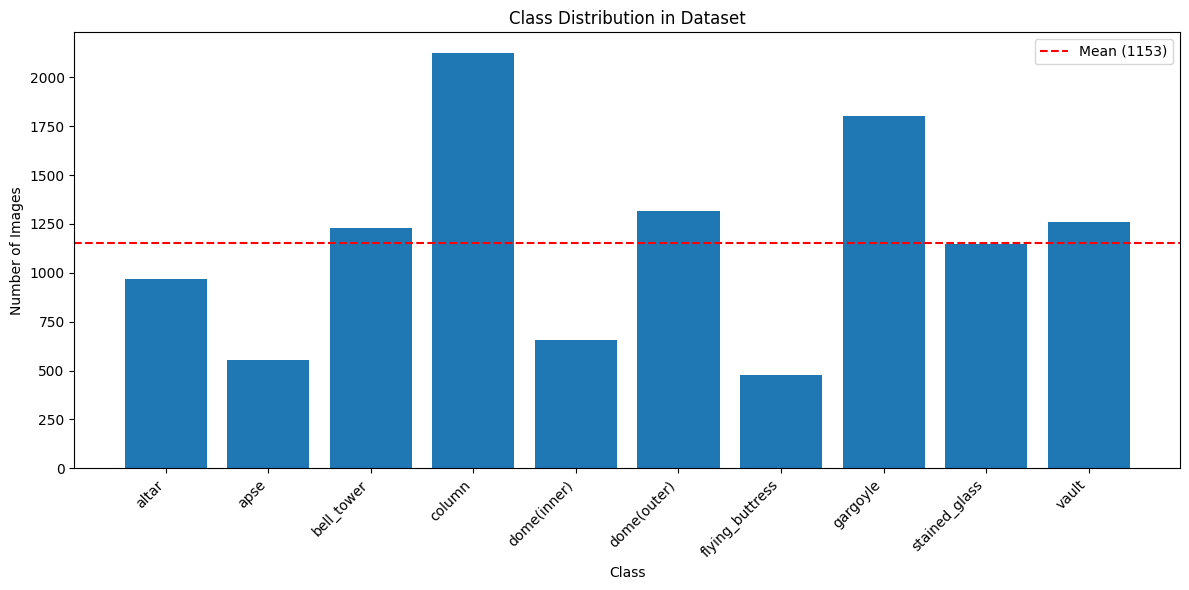

In [ ]:
class_dirs = [d for d in data_path.iterdir() if d.is_dir()]
classes = sorted([d.name for d in class_dirs])
class_to_idx = {c: i for i, c in enumerate(classes)}

pairs = []
non_jpg_files = []

for class_dir in class_dirs:
    for img_path in class_dir.rglob("*"):
        if img_path.is_file():
            if img_path.suffix.lower() in [".jpg"]:
                pairs.append((str(img_path), class_to_idx[class_dir.name]))
            else:
                non_jpg_files.append(img_path)

# Summary Text
print(f"Found {len(pairs)} images across {len(classes)} classes.")
print("Classes:", classes)
print("\n")

counts = Counter([label for _, label in pairs])
for i, c in enumerate(classes):
    print(f"{c:20s} -> {counts.get(i, 0)} images")

if non_jpg_files:
    print(f"Warning: Found {len(non_jpg_files)} non-jpg files:")
else:
    print("\nAll files are in .jpg")

# Visualise class distribution
plt.figure(figsize=(12, 6))
values = [counts.get(i, 0) for i in range(len(classes))]
total_images = len(pairs)

plt.bar(classes, values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Dataset')

mean_val = total_images / len(classes)

plt.axhline(y=mean_val, color='r', linestyle='--', label=f'Mean ({int(mean_val)})')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
rng = np.random.default_rng(SEED)

by_class = {}
for file_path, label in pairs:
    if label not in by_class:
        by_class[label] = []
    by_class[label].append(file_path)

train_pairs, val_pairs, test_pairs = [], [], []
train_ratio, val_ratio = 0.7, 0.15
for lbl, files in by_class.items():
    rng.shuffle(files)
    n = len(files)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    train_pairs += [(fp, lbl) for fp in files[:n_train]]
    val_pairs   += [(fp, lbl) for fp in files[n_train:n_train+n_val]]
    test_pairs  += [(fp, lbl) for fp in files[n_train+n_val:]]

pd.DataFrame(train_pairs, columns=["filepath", "label"]).to_csv(split_path/"train.csv", index=False)
pd.DataFrame(val_pairs, columns=["filepath", "label"]).to_csv(split_path/"val.csv", index=False)
pd.DataFrame(test_pairs, columns=["filepath", "label"]).to_csv(split_path/"test.csv", index=False)

In [ ]:
n = 0
channel_sum = torch.zeros(3)
channel_sum_sq = torch.zeros(3)

train_filepaths = [fp for fp, _ in train_pairs]
sample_paths = random.sample(train_filepaths, min(1000, len(train_filepaths)))

for file_path in sample_paths:
    img = Image.open(file_path).convert("RGB").resize((64, 64))
    img = np.array(img) / 255.0
    img = torch.tensor(img).permute(2,0,1)
    n += img.numel() / 3
    channel_sum += img.sum(dim=(1,2))
    channel_sum_sq += (img**2).sum(dim=(1,2))

mean_tensor = channel_sum / n
std_tensor = (channel_sum_sq / n - mean_tensor**2).sqrt()

mean = mean_tensor.tolist()
std = std_tensor.tolist()

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Create dataset and dataloader objects
class ImageDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img = Image.open(row['filepath']).convert("RGB")
        label = int(row['label'])
        if self.transform:
            img = self.transform(img)
        return img, label

train_ds = ImageDataset(split_path/"train.csv", transform=train_transform)
val_ds = ImageDataset(split_path/"val.csv", transform=val_test_transform)
test_ds = ImageDataset(split_path/"test.csv", transform=val_test_transform)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128)
test_loader  = DataLoader(test_ds, batch_size=128)

In [ ]:
all_labels = []
for _, labels in train_loader:
    all_labels.extend(labels.numpy())

# Compute weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

# Convert to torch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32)

---

# 2. **Neural Networks**

Define:
1. Custom CNN architecture (efficient in parameters)
2. Existing CNN (ResNet18) with different training strategies
3. Training components and procedures

In [ ]:
class OurCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(OurCNN, self).__init__()

        # Initial standard convolution
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Block 1
        self.dw_conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1, groups=32)
        self.pw_conv2 = nn.Conv2d(32, 64, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Block 2
        self.dw_conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, groups=64)
        self.pw_conv3 = nn.Conv2d(64, 128, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Block 3
        self.dw_conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, groups=128)

        self.pw_conv4 = nn.Conv2d(128, num_classes, kernel_size=1)
        self.bn4 = nn.BatchNorm2d(num_classes)

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.pw_conv2(self.dw_conv2(x))))
        x = F.relu(self.bn3(self.pw_conv3(self.dw_conv3(x))))

        # Final block
        x = F.relu(self.bn4(self.pw_conv4(self.dw_conv4(x))))

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        return x

In [ ]:
# Define ResNet18 with different strategies
def resnet18(num_classes=10, strategy='scratch'):
    if strategy == 'scratch':
        # Train from scratch
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif strategy == 'finetune':
        # Use pretrained weights and train all layers
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif strategy == 'feature_extractor':
        # Feature extractor where all layers are frozen except the last
        model = models.resnet18(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        model.fc = nn.Linear(model.fc.in_features, num_classes)
        model.fc.weight.requires_grad = True
        model.fc.bias.requires_grad = True

    return model

# Check parameter counts for each strategy
for strategy in ['scratch', 'finetune', 'feature_extractor']:
    model = resnet18(10, strategy)
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'ResNet18 ({strategy}) - Trainable parameters: {trainable:,}')

ResNet18 (scratch) - Trainable parameters: 11,181,642
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


ResNet18 (finetune) - Trainable parameters: 11,181,642
ResNet18 (feature_extractor) - Trainable parameters: 5,130


In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=30, learning_rate=0.001, patience=7, model_name='Model'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    best_val_acc = 0
    epochs_no_improve = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation Phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Early Stopping Logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc

            torch.save(model.state_dict(), f'{model_name}_best.pth')
            epochs_no_improve = 0

            print(f"New best model saved ({val_acc:.2f}%)")

        else:
            epochs_no_improve += 1

            print(f"No improvement. Patience: {epochs_no_improve}/{patience}")

            if epochs_no_improve >= patience:
                print(f"Early stopping triggered. Best Accuracy: {best_val_acc:.2f}%")
                break

    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{model_name} - Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(train_accs, label='Train Acc')
    ax2.plot(val_accs, label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{model_name} - Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Load best model before returning
    model.load_state_dict(torch.load(f'{model_name}_best.pth'))

    return model, best_val_acc

In [ ]:
# Initialise the custom CNN
print('Training Custom CNN...')

custom_model = OurCNN(num_classes=10)
custom_model = custom_model.to(device)

# Use SGD with Momentum and L2 Regularisation (Weight Decay)
optimizer = optim.SGD(
    custom_model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4
)

# Train Custom CNN from scratch
custom_model, custom_val_acc = train_model(
    custom_model,
    train_loader,
    val_loader,
    num_epochs=100,
    learning_rate=0.001,
    patience=10,
    model_name='Custom_CNN'
)

print(f"Final Best Validation Accuracy: {custom_val_acc:.2f}%")

Training Custom CNN...


Epoch 1/100: 100%|██████████| 64/64 [01:06<00:00,  1.04s/it]


Epoch 1: Train Loss: 2.0157, Train Acc: 28.59%, Val Loss: 1.8718, Val Acc: 36.94%
New best model saved (36.94%)


Epoch 2/100: 100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Epoch 2: Train Loss: 1.7964, Train Acc: 41.00%, Val Loss: 1.7321, Val Acc: 47.02%
New best model saved (47.02%)


Epoch 3/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 3: Train Loss: 1.6991, Train Acc: 47.10%, Val Loss: 1.6397, Val Acc: 50.32%
New best model saved (50.32%)


Epoch 4/100: 100%|██████████| 64/64 [01:06<00:00,  1.04s/it]


Epoch 4: Train Loss: 1.6097, Train Acc: 51.67%, Val Loss: 1.5164, Val Acc: 53.97%
New best model saved (53.97%)


Epoch 5/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 5: Train Loss: 1.5355, Train Acc: 54.25%, Val Loss: 1.4914, Val Acc: 55.24%
New best model saved (55.24%)


Epoch 6/100: 100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Epoch 6: Train Loss: 1.4860, Train Acc: 55.95%, Val Loss: 1.4290, Val Acc: 57.96%
New best model saved (57.96%)


Epoch 7/100: 100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Epoch 7: Train Loss: 1.4324, Train Acc: 57.40%, Val Loss: 1.4083, Val Acc: 56.98%
No improvement. Patience: 1/10


Epoch 8/100: 100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Epoch 8: Train Loss: 1.3785, Train Acc: 59.38%, Val Loss: 1.3225, Val Acc: 61.90%
New best model saved (61.90%)


Epoch 9/100: 100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Epoch 9: Train Loss: 1.3560, Train Acc: 59.88%, Val Loss: 1.2592, Val Acc: 62.77%
New best model saved (62.77%)


Epoch 10/100: 100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Epoch 10: Train Loss: 1.3071, Train Acc: 60.99%, Val Loss: 1.2421, Val Acc: 63.00%
New best model saved (63.00%)


Epoch 11/100: 100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Epoch 11: Train Loss: 1.2657, Train Acc: 62.63%, Val Loss: 1.2356, Val Acc: 62.36%
No improvement. Patience: 1/10


Epoch 12/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 12: Train Loss: 1.2295, Train Acc: 63.92%, Val Loss: 1.2183, Val Acc: 62.19%
No improvement. Patience: 2/10


Epoch 13/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 13: Train Loss: 1.2154, Train Acc: 64.34%, Val Loss: 1.1363, Val Acc: 67.17%
New best model saved (67.17%)


Epoch 14/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 14: Train Loss: 1.1953, Train Acc: 64.90%, Val Loss: 1.1946, Val Acc: 63.52%
No improvement. Patience: 1/10


Epoch 15/100: 100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Epoch 15: Train Loss: 1.1738, Train Acc: 65.27%, Val Loss: 1.1485, Val Acc: 65.26%
No improvement. Patience: 2/10


Epoch 16/100: 100%|██████████| 64/64 [01:01<00:00,  1.03it/s]


Epoch 16: Train Loss: 1.1318, Train Acc: 66.61%, Val Loss: 1.0880, Val Acc: 68.33%
New best model saved (68.33%)


Epoch 17/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 17: Train Loss: 1.1161, Train Acc: 67.32%, Val Loss: 1.0890, Val Acc: 66.82%
No improvement. Patience: 1/10


Epoch 18/100: 100%|██████████| 64/64 [01:00<00:00,  1.07it/s]


Epoch 18: Train Loss: 1.0797, Train Acc: 68.63%, Val Loss: 1.0274, Val Acc: 69.89%
New best model saved (69.89%)


Epoch 19/100: 100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Epoch 19: Train Loss: 1.0682, Train Acc: 68.68%, Val Loss: 1.0177, Val Acc: 70.24%
New best model saved (70.24%)


Epoch 20/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 20: Train Loss: 1.0566, Train Acc: 68.90%, Val Loss: 1.0084, Val Acc: 69.54%
No improvement. Patience: 1/10


Epoch 21/100: 100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Epoch 21: Train Loss: 1.0168, Train Acc: 70.28%, Val Loss: 1.0382, Val Acc: 68.09%
No improvement. Patience: 2/10


Epoch 22/100: 100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Epoch 22: Train Loss: 1.0246, Train Acc: 70.20%, Val Loss: 1.0459, Val Acc: 66.65%
No improvement. Patience: 3/10


Epoch 23/100: 100%|██████████| 64/64 [00:59<00:00,  1.07it/s]


Epoch 23: Train Loss: 1.0237, Train Acc: 70.36%, Val Loss: 1.0887, Val Acc: 64.39%
No improvement. Patience: 4/10


Epoch 24/100: 100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Epoch 24: Train Loss: 1.0077, Train Acc: 70.84%, Val Loss: 0.9961, Val Acc: 69.43%
No improvement. Patience: 5/10


Epoch 25/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 25: Train Loss: 0.9620, Train Acc: 71.44%, Val Loss: 0.9315, Val Acc: 71.69%
New best model saved (71.69%)


Epoch 26/100: 100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Epoch 26: Train Loss: 0.9404, Train Acc: 72.15%, Val Loss: 0.9576, Val Acc: 71.74%
New best model saved (71.74%)


Epoch 27/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 27: Train Loss: 0.9434, Train Acc: 72.38%, Val Loss: 0.9193, Val Acc: 72.79%
New best model saved (72.79%)


Epoch 28/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 28: Train Loss: 0.9154, Train Acc: 73.59%, Val Loss: 0.8740, Val Acc: 73.02%
New best model saved (73.02%)


Epoch 29/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 29: Train Loss: 0.9277, Train Acc: 72.57%, Val Loss: 0.8787, Val Acc: 74.23%
New best model saved (74.23%)


Epoch 30/100: 100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Epoch 30: Train Loss: 0.9072, Train Acc: 73.07%, Val Loss: 0.8660, Val Acc: 73.94%
No improvement. Patience: 1/10


Epoch 31/100: 100%|██████████| 64/64 [01:01<00:00,  1.03it/s]


Epoch 31: Train Loss: 0.8838, Train Acc: 73.25%, Val Loss: 0.9082, Val Acc: 71.69%
No improvement. Patience: 2/10


Epoch 32/100: 100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Epoch 32: Train Loss: 0.8967, Train Acc: 74.10%, Val Loss: 0.8955, Val Acc: 73.65%
No improvement. Patience: 3/10


Epoch 33/100: 100%|██████████| 64/64 [01:01<00:00,  1.03it/s]


Epoch 33: Train Loss: 0.8590, Train Acc: 74.85%, Val Loss: 0.8820, Val Acc: 72.55%
No improvement. Patience: 4/10


Epoch 34/100: 100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Epoch 34: Train Loss: 0.8591, Train Acc: 74.59%, Val Loss: 0.8110, Val Acc: 74.81%
New best model saved (74.81%)


Epoch 35/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 35: Train Loss: 0.8284, Train Acc: 75.20%, Val Loss: 0.8030, Val Acc: 76.32%
New best model saved (76.32%)


Epoch 36/100: 100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Epoch 36: Train Loss: 0.8208, Train Acc: 76.28%, Val Loss: 0.8340, Val Acc: 73.19%
No improvement. Patience: 1/10


Epoch 37/100: 100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Epoch 37: Train Loss: 0.8094, Train Acc: 75.67%, Val Loss: 0.8704, Val Acc: 73.36%
No improvement. Patience: 2/10


Epoch 38/100: 100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Epoch 38: Train Loss: 0.8236, Train Acc: 75.29%, Val Loss: 0.8271, Val Acc: 74.12%
No improvement. Patience: 3/10


Epoch 39/100: 100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Epoch 39: Train Loss: 0.7996, Train Acc: 75.57%, Val Loss: 0.7746, Val Acc: 76.66%
New best model saved (76.66%)


Epoch 40/100: 100%|██████████| 64/64 [01:01<00:00,  1.03it/s]


Epoch 40: Train Loss: 0.7926, Train Acc: 76.30%, Val Loss: 0.7866, Val Acc: 75.22%
No improvement. Patience: 1/10


Epoch 41/100: 100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Epoch 41: Train Loss: 0.7752, Train Acc: 76.38%, Val Loss: 0.7911, Val Acc: 74.41%
No improvement. Patience: 2/10


Epoch 42/100: 100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Epoch 42: Train Loss: 0.7780, Train Acc: 76.74%, Val Loss: 0.7859, Val Acc: 76.09%
No improvement. Patience: 3/10


Epoch 43/100: 100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Epoch 43: Train Loss: 0.7752, Train Acc: 77.03%, Val Loss: 0.7680, Val Acc: 76.14%
No improvement. Patience: 4/10


Epoch 44/100: 100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Epoch 44: Train Loss: 0.7590, Train Acc: 77.66%, Val Loss: 0.7323, Val Acc: 76.84%
New best model saved (76.84%)


Epoch 45/100: 100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Epoch 45: Train Loss: 0.7423, Train Acc: 77.47%, Val Loss: 0.7551, Val Acc: 76.20%
No improvement. Patience: 1/10


Epoch 46/100: 100%|██████████| 64/64 [00:59<00:00,  1.07it/s]


Epoch 46: Train Loss: 0.7301, Train Acc: 78.27%, Val Loss: 0.7277, Val Acc: 77.30%
New best model saved (77.30%)


Epoch 47/100: 100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Epoch 47: Train Loss: 0.7259, Train Acc: 77.78%, Val Loss: 0.7364, Val Acc: 77.65%
New best model saved (77.65%)


Epoch 48/100: 100%|██████████| 64/64 [00:58<00:00,  1.09it/s]


Epoch 48: Train Loss: 0.7225, Train Acc: 78.58%, Val Loss: 0.7198, Val Acc: 77.53%
No improvement. Patience: 1/10


Epoch 49/100: 100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Epoch 49: Train Loss: 0.7390, Train Acc: 77.95%, Val Loss: 0.7576, Val Acc: 76.66%
No improvement. Patience: 2/10


Epoch 50/100: 100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Epoch 50: Train Loss: 0.7033, Train Acc: 78.61%, Val Loss: 0.7416, Val Acc: 76.09%
No improvement. Patience: 3/10


Epoch 51/100: 100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Epoch 51: Train Loss: 0.7163, Train Acc: 78.57%, Val Loss: 0.7249, Val Acc: 76.90%
No improvement. Patience: 4/10


Epoch 52/100: 100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Epoch 52: Train Loss: 0.6923, Train Acc: 79.25%, Val Loss: 0.7048, Val Acc: 78.46%
New best model saved (78.46%)


Epoch 53/100: 100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Epoch 53: Train Loss: 0.7394, Train Acc: 78.41%, Val Loss: 0.7375, Val Acc: 76.66%
No improvement. Patience: 1/10


Epoch 54/100: 100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Epoch 54: Train Loss: 0.6891, Train Acc: 79.21%, Val Loss: 0.6970, Val Acc: 79.27%
New best model saved (79.27%)


Epoch 55/100: 100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Epoch 55: Train Loss: 0.6627, Train Acc: 79.77%, Val Loss: 0.7009, Val Acc: 78.34%
No improvement. Patience: 1/10


Epoch 56/100: 100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Epoch 56: Train Loss: 0.6870, Train Acc: 79.42%, Val Loss: 0.6927, Val Acc: 78.23%
No improvement. Patience: 2/10


Epoch 57/100: 100%|██████████| 64/64 [00:59<00:00,  1.07it/s]


Epoch 57: Train Loss: 0.6771, Train Acc: 79.52%, Val Loss: 0.7098, Val Acc: 78.11%
No improvement. Patience: 3/10


Epoch 58/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 58: Train Loss: 0.6479, Train Acc: 80.28%, Val Loss: 0.7072, Val Acc: 78.00%
No improvement. Patience: 4/10


Epoch 59/100: 100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Epoch 59: Train Loss: 0.6644, Train Acc: 79.16%, Val Loss: 0.7216, Val Acc: 77.65%
No improvement. Patience: 5/10


Epoch 60/100: 100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Epoch 60: Train Loss: 0.6393, Train Acc: 80.06%, Val Loss: 0.7321, Val Acc: 76.14%
No improvement. Patience: 6/10


Epoch 61/100: 100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Epoch 61: Train Loss: 0.6302, Train Acc: 81.26%, Val Loss: 0.6587, Val Acc: 79.79%
New best model saved (79.79%)


Epoch 62/100: 100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Epoch 62: Train Loss: 0.6245, Train Acc: 81.17%, Val Loss: 0.6485, Val Acc: 80.60%
New best model saved (80.60%)


Epoch 63/100: 100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Epoch 63: Train Loss: 0.6141, Train Acc: 81.35%, Val Loss: 0.6545, Val Acc: 78.63%
No improvement. Patience: 1/10


Epoch 64/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 64: Train Loss: 0.6064, Train Acc: 81.84%, Val Loss: 0.6513, Val Acc: 79.39%
No improvement. Patience: 2/10


Epoch 65/100: 100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Epoch 65: Train Loss: 0.5974, Train Acc: 82.14%, Val Loss: 0.6667, Val Acc: 79.15%
No improvement. Patience: 3/10


Epoch 66/100: 100%|██████████| 64/64 [01:01<00:00,  1.03it/s]


Epoch 66: Train Loss: 0.5896, Train Acc: 82.37%, Val Loss: 0.6670, Val Acc: 78.75%
No improvement. Patience: 4/10


Epoch 67/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 67: Train Loss: 0.6035, Train Acc: 82.52%, Val Loss: 0.6222, Val Acc: 80.66%
New best model saved (80.66%)


Epoch 68/100: 100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Epoch 68: Train Loss: 0.5930, Train Acc: 82.77%, Val Loss: 0.6168, Val Acc: 81.12%
New best model saved (81.12%)


Epoch 69/100: 100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Epoch 69: Train Loss: 0.5801, Train Acc: 83.23%, Val Loss: 0.6402, Val Acc: 80.25%
No improvement. Patience: 1/10


Epoch 70/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 70: Train Loss: 0.5746, Train Acc: 83.21%, Val Loss: 0.6429, Val Acc: 79.97%
No improvement. Patience: 2/10


Epoch 71/100: 100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Epoch 71: Train Loss: 0.5982, Train Acc: 82.67%, Val Loss: 0.6542, Val Acc: 79.39%
No improvement. Patience: 3/10


Epoch 72/100: 100%|██████████| 64/64 [01:01<00:00,  1.03it/s]


Epoch 72: Train Loss: 0.5648, Train Acc: 83.37%, Val Loss: 0.6343, Val Acc: 80.72%
No improvement. Patience: 4/10


Epoch 73/100: 100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Epoch 73: Train Loss: 0.5718, Train Acc: 83.95%, Val Loss: 0.6246, Val Acc: 80.89%
No improvement. Patience: 5/10


Epoch 74/100: 100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Epoch 74: Train Loss: 0.5587, Train Acc: 83.73%, Val Loss: 0.6325, Val Acc: 80.08%
No improvement. Patience: 6/10


Epoch 75/100: 100%|██████████| 64/64 [01:00<00:00,  1.06it/s]


Epoch 75: Train Loss: 0.5575, Train Acc: 83.23%, Val Loss: 0.6306, Val Acc: 80.60%
No improvement. Patience: 7/10


Epoch 76/100: 100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Epoch 76: Train Loss: 0.5731, Train Acc: 83.32%, Val Loss: 0.6103, Val Acc: 81.24%
New best model saved (81.24%)


Epoch 77/100: 100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Epoch 77: Train Loss: 0.5721, Train Acc: 82.76%, Val Loss: 0.6195, Val Acc: 80.31%
No improvement. Patience: 1/10


Epoch 78/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 78: Train Loss: 0.5595, Train Acc: 83.78%, Val Loss: 0.6520, Val Acc: 79.56%
No improvement. Patience: 2/10


Epoch 79/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 79: Train Loss: 0.5585, Train Acc: 83.45%, Val Loss: 0.6202, Val Acc: 80.95%
No improvement. Patience: 3/10


Epoch 80/100: 100%|██████████| 64/64 [01:02<00:00,  1.03it/s]


Epoch 80: Train Loss: 0.5536, Train Acc: 83.17%, Val Loss: 0.6313, Val Acc: 80.43%
No improvement. Patience: 4/10


Epoch 81/100: 100%|██████████| 64/64 [01:03<00:00,  1.01it/s]


Epoch 81: Train Loss: 0.5358, Train Acc: 84.11%, Val Loss: 0.6303, Val Acc: 80.43%
No improvement. Patience: 5/10


Epoch 82/100: 100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Epoch 82: Train Loss: 0.5522, Train Acc: 83.90%, Val Loss: 0.6217, Val Acc: 80.95%
No improvement. Patience: 6/10


Epoch 83/100: 100%|██████████| 64/64 [01:01<00:00,  1.04it/s]


Epoch 83: Train Loss: 0.5415, Train Acc: 83.84%, Val Loss: 0.6154, Val Acc: 80.89%
No improvement. Patience: 7/10


Epoch 84/100: 100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Epoch 84: Train Loss: 0.5488, Train Acc: 83.91%, Val Loss: 0.6329, Val Acc: 79.85%
No improvement. Patience: 8/10


Epoch 85/100: 100%|██████████| 64/64 [01:01<00:00,  1.05it/s]


Epoch 85: Train Loss: 0.5574, Train Acc: 83.86%, Val Loss: 0.6171, Val Acc: 81.01%
No improvement. Patience: 9/10


Epoch 86/100: 100%|██████████| 64/64 [01:00<00:00,  1.05it/s]


Epoch 86: Train Loss: 0.5452, Train Acc: 83.90%, Val Loss: 0.6311, Val Acc: 80.25%
No improvement. Patience: 10/10
Early stopping triggered. Best Accuracy: 81.24%
Final Best Validation Accuracy: 81.24%


In [ ]:
# Train ResNet18 from scratch
print('Training ResNet18 from scratch...')

resnet_scratch = resnet18(num_classes=10, strategy='scratch')

resnet_scratch, scratch_val_acc = train_model(
    resnet_scratch,
    train_loader,
    val_loader,
    num_epochs=30,
    learning_rate=0.001,
    model_name='ResNet_Scratch'
)

Training ResNet18 from scratch...


Epoch 1/30: 100%|██████████| 64/64 [04:36<00:00,  4.32s/it]


Epoch 1: Train Loss: 1.5189, Train Acc: 44.45%, Val Loss: 1.6812, Val Acc: 46.73%
New best model saved (46.73%)


Epoch 2/30: 100%|██████████| 64/64 [04:32<00:00,  4.26s/it]


Epoch 2: Train Loss: 1.2045, Train Acc: 57.98%, Val Loss: 1.0404, Val Acc: 66.36%
New best model saved (66.36%)


Epoch 3/30: 100%|██████████| 64/64 [04:23<00:00,  4.12s/it]


Epoch 3: Train Loss: 1.0038, Train Acc: 66.22%, Val Loss: 1.1557, Val Acc: 65.43%
No improvement. Patience: 1/7


Epoch 4/30: 100%|██████████| 64/64 [04:22<00:00,  4.10s/it]


Epoch 4: Train Loss: 0.9047, Train Acc: 69.27%, Val Loss: 1.2056, Val Acc: 62.02%
No improvement. Patience: 2/7


Epoch 5/30: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]


Epoch 5: Train Loss: 0.7360, Train Acc: 74.27%, Val Loss: 0.8556, Val Acc: 72.21%
New best model saved (72.21%)


Epoch 6/30: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]


Epoch 6: Train Loss: 0.6978, Train Acc: 75.87%, Val Loss: 0.8185, Val Acc: 74.17%
New best model saved (74.17%)


Epoch 7/30: 100%|██████████| 64/64 [04:22<00:00,  4.11s/it]


Epoch 7: Train Loss: 0.6826, Train Acc: 75.77%, Val Loss: 0.7647, Val Acc: 74.46%
New best model saved (74.46%)


Epoch 8/30: 100%|██████████| 64/64 [04:22<00:00,  4.10s/it]


Epoch 8: Train Loss: 0.5753, Train Acc: 80.35%, Val Loss: 0.8381, Val Acc: 71.92%
No improvement. Patience: 1/7


Epoch 9/30: 100%|██████████| 64/64 [04:21<00:00,  4.08s/it]


Epoch 9: Train Loss: 0.5634, Train Acc: 79.26%, Val Loss: 0.6869, Val Acc: 78.63%
New best model saved (78.63%)


Epoch 10/30: 100%|██████████| 64/64 [04:22<00:00,  4.11s/it]


Epoch 10: Train Loss: 0.4080, Train Acc: 85.25%, Val Loss: 0.7973, Val Acc: 75.45%
No improvement. Patience: 1/7


Epoch 11/30: 100%|██████████| 64/64 [04:21<00:00,  4.09s/it]


Epoch 11: Train Loss: 0.3995, Train Acc: 85.62%, Val Loss: 0.9615, Val Acc: 71.34%
No improvement. Patience: 2/7


Epoch 12/30: 100%|██████████| 64/64 [04:22<00:00,  4.11s/it]


Epoch 12: Train Loss: 0.4358, Train Acc: 83.08%, Val Loss: 0.6956, Val Acc: 78.81%
New best model saved (78.81%)


Epoch 13/30: 100%|██████████| 64/64 [04:23<00:00,  4.12s/it]


Epoch 13: Train Loss: 0.2853, Train Acc: 89.58%, Val Loss: 0.6096, Val Acc: 80.54%
New best model saved (80.54%)


Epoch 14/30: 100%|██████████| 64/64 [04:22<00:00,  4.11s/it]


Epoch 14: Train Loss: 0.2383, Train Acc: 90.74%, Val Loss: 0.8164, Val Acc: 78.81%
No improvement. Patience: 1/7


Epoch 15/30: 100%|██████████| 64/64 [04:21<00:00,  4.09s/it]


Epoch 15: Train Loss: 0.3297, Train Acc: 88.06%, Val Loss: 0.5987, Val Acc: 81.01%
New best model saved (81.01%)


Epoch 16/30: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]


Epoch 16: Train Loss: 0.2371, Train Acc: 90.91%, Val Loss: 0.6984, Val Acc: 80.08%
No improvement. Patience: 1/7


Epoch 17/30: 100%|██████████| 64/64 [04:25<00:00,  4.15s/it]


Epoch 17: Train Loss: 0.2056, Train Acc: 93.03%, Val Loss: 0.9728, Val Acc: 75.80%
No improvement. Patience: 2/7


Epoch 18/30: 100%|██████████| 64/64 [04:24<00:00,  4.14s/it]


Epoch 18: Train Loss: 0.4451, Train Acc: 85.09%, Val Loss: 0.7181, Val Acc: 78.52%
No improvement. Patience: 3/7


Epoch 19/30: 100%|██████████| 64/64 [04:24<00:00,  4.14s/it]


Epoch 19: Train Loss: 0.2954, Train Acc: 89.25%, Val Loss: 0.6152, Val Acc: 80.83%
No improvement. Patience: 4/7


Epoch 20/30: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]


Epoch 20: Train Loss: 0.1969, Train Acc: 93.01%, Val Loss: 0.5017, Val Acc: 85.47%
New best model saved (85.47%)


Epoch 21/30: 100%|██████████| 64/64 [04:23<00:00,  4.11s/it]


Epoch 21: Train Loss: 0.1286, Train Acc: 95.58%, Val Loss: 0.5745, Val Acc: 83.27%
No improvement. Patience: 1/7


Epoch 22/30: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]


Epoch 22: Train Loss: 0.2293, Train Acc: 91.91%, Val Loss: 0.5918, Val Acc: 83.21%
No improvement. Patience: 2/7


Epoch 23/30: 100%|██████████| 64/64 [04:25<00:00,  4.16s/it]


Epoch 23: Train Loss: 0.1628, Train Acc: 94.34%, Val Loss: 0.6128, Val Acc: 83.15%
No improvement. Patience: 3/7


Epoch 24/30: 100%|██████████| 64/64 [04:23<00:00,  4.11s/it]


Epoch 24: Train Loss: 0.1271, Train Acc: 94.98%, Val Loss: 0.5245, Val Acc: 85.58%
New best model saved (85.58%)


Epoch 25/30: 100%|██████████| 64/64 [04:23<00:00,  4.12s/it]


Epoch 25: Train Loss: 0.0693, Train Acc: 97.62%, Val Loss: 0.5427, Val Acc: 85.93%
New best model saved (85.93%)


Epoch 26/30: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]


Epoch 26: Train Loss: 0.0950, Train Acc: 97.79%, Val Loss: 0.5440, Val Acc: 86.28%
New best model saved (86.28%)


Epoch 27/30: 100%|██████████| 64/64 [04:26<00:00,  4.16s/it]


Epoch 27: Train Loss: 0.1096, Train Acc: 95.82%, Val Loss: 0.5589, Val Acc: 85.99%
No improvement. Patience: 1/7


Epoch 28/30: 100%|██████████| 64/64 [04:26<00:00,  4.16s/it]


Epoch 28: Train Loss: 0.0688, Train Acc: 97.87%, Val Loss: 0.5463, Val Acc: 86.10%
No improvement. Patience: 2/7


Epoch 29/30: 100%|██████████| 64/64 [04:28<00:00,  4.19s/it]


Epoch 29: Train Loss: 0.0624, Train Acc: 97.82%, Val Loss: 0.5831, Val Acc: 85.35%
No improvement. Patience: 3/7


Epoch 30/30: 100%|██████████| 64/64 [04:28<00:00,  4.19s/it]


Epoch 30: Train Loss: 0.0499, Train Acc: 98.70%, Val Loss: 0.5673, Val Acc: 86.28%
No improvement. Patience: 4/7


In [ ]:
# Train ResNet18 with fine-tuning
print('Fine-tuning ResNet18...')

resnet_finetune = resnet18(num_classes=10, strategy='finetune')

resnet_finetune, finetune_val_acc = train_model(
    resnet_finetune,
    train_loader,
    val_loader,
    num_epochs=20,
    learning_rate=0.0001,
    model_name='ResNet_Finetune'
)

Fine-tuning ResNet18...


Epoch 1/20: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]


Epoch 1: Train Loss: 0.8793, Train Acc: 72.01%, Val Loss: 0.3600, Val Acc: 88.25%
New best model saved (88.25%)


Epoch 2/20: 100%|██████████| 64/64 [04:26<00:00,  4.16s/it]


Epoch 2: Train Loss: 0.3202, Train Acc: 89.79%, Val Loss: 0.2851, Val Acc: 90.62%
New best model saved (90.62%)


Epoch 3/20: 100%|██████████| 64/64 [04:27<00:00,  4.19s/it]


Epoch 3: Train Loss: 0.2290, Train Acc: 93.38%, Val Loss: 0.2594, Val Acc: 91.66%
New best model saved (91.66%)


Epoch 4/20: 100%|██████████| 64/64 [04:23<00:00,  4.11s/it]


Epoch 4: Train Loss: 0.1893, Train Acc: 94.45%, Val Loss: 0.2722, Val Acc: 91.14%
No improvement. Patience: 1/7


Epoch 5/20: 100%|██████████| 64/64 [04:26<00:00,  4.17s/it]


Epoch 5: Train Loss: 0.1221, Train Acc: 96.05%, Val Loss: 0.2516, Val Acc: 92.30%
New best model saved (92.30%)


Epoch 6/20: 100%|██████████| 64/64 [04:29<00:00,  4.22s/it]


Epoch 6: Train Loss: 0.1007, Train Acc: 96.69%, Val Loss: 0.2351, Val Acc: 93.05%
New best model saved (93.05%)


Epoch 7/20: 100%|██████████| 64/64 [04:26<00:00,  4.17s/it]


Epoch 7: Train Loss: 0.1114, Train Acc: 97.29%, Val Loss: 0.2261, Val Acc: 93.23%
New best model saved (93.23%)


Epoch 8/20: 100%|██████████| 64/64 [04:26<00:00,  4.16s/it]


Epoch 8: Train Loss: 0.0917, Train Acc: 97.17%, Val Loss: 0.2323, Val Acc: 93.57%
New best model saved (93.57%)


Epoch 9/20: 100%|██████████| 64/64 [04:28<00:00,  4.19s/it]


Epoch 9: Train Loss: 0.0845, Train Acc: 97.43%, Val Loss: 0.2375, Val Acc: 93.17%
No improvement. Patience: 1/7


Epoch 10/20: 100%|██████████| 64/64 [04:25<00:00,  4.14s/it]


Epoch 10: Train Loss: 0.0640, Train Acc: 97.94%, Val Loss: 0.2570, Val Acc: 92.70%
No improvement. Patience: 2/7


Epoch 11/20: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]


Epoch 11: Train Loss: 0.0441, Train Acc: 98.50%, Val Loss: 0.2360, Val Acc: 93.86%
New best model saved (93.86%)


Epoch 12/20: 100%|██████████| 64/64 [04:25<00:00,  4.14s/it]


Epoch 12: Train Loss: 0.0800, Train Acc: 98.91%, Val Loss: 0.2258, Val Acc: 93.28%
No improvement. Patience: 1/7


Epoch 13/20: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]


Epoch 13: Train Loss: 0.0297, Train Acc: 99.07%, Val Loss: 0.2400, Val Acc: 93.69%
No improvement. Patience: 2/7


Epoch 14/20: 100%|██████████| 64/64 [04:22<00:00,  4.11s/it]


Epoch 14: Train Loss: 0.0602, Train Acc: 99.31%, Val Loss: 0.2422, Val Acc: 93.28%
No improvement. Patience: 3/7


Epoch 15/20:  11%|█         | 7/64 [00:28<03:47,  3.99s/it]

In [ ]:
# Train ResNet18 as feature extractor
print('Training ResNet18 as feature extractor...')

resnet_feature = resnet18(num_classes=10, strategy='feature_extractor')

resnet_feature, feature_val_acc = train_model(
    resnet_feature,
    train_loader,
    val_loader,
    num_epochs=15,
    learning_rate=0.001,
    model_name='ResNet_Feature'
)

In [ ]:
# Compare results
results = {
    'Custom CNN': custom_val_acc,
    'ResNet18 Scratch': scratch_val_acc,
    'ResNet18 Fine-tune': finetune_val_acc,
    'ResNet18 Feature': feature_val_acc
}

for model_name, acc in results.items():
    print(f'{model_name:<25}: {acc:.2f}%')

best_model_name = max(results, key=results.get)
print(f'\nBest Model: {best_model_name} with {results[best_model_name]:.2f}% validation accuracy')

---

# 3. **Evaluate Models**

Evaluate the best model on the test set using multiple metrics

In [ ]:
# Select the best model based on validation accuracy
models_dict = {
    'Custom CNN': custom_model,
    'ResNet18 Scratch': resnet_scratch,
    'ResNet18 Fine-tune': resnet_finetune,
    'ResNet18 Feature': resnet_feature
}

best_model = models_dict[best_model_name]
print(f'Evaluating best model: {best_model_name}')

In [ ]:
# Evaluation function
def evaluate_model(model, test_loader, num_classes=10):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Per-class metrics
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    f1_per_class = f1_score(all_labels, all_preds, average=None)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class
    }

# Evaluate the best model
test_results = evaluate_model(best_model, test_loader)

In [ ]:
# Display results
print(f"Accuracy: {test_results['accuracy']:.4f}")
print(f"Precision (weighted): {test_results['precision']:.4f}")
print(f"Recall (weighted): {test_results['recall']:.4f}")
print(f"F1-Score (weighted): {test_results['f1']:.4f}")

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print('\nPer-Class Metrics:')
for i in range(10):
    print(f"Class {i}: Precision={test_results['precision_per_class'][i]:.3f}, "
          f"Recall={test_results['recall_per_class'][i]:.3f}, "
          f"F1={test_results['f1_per_class'][i]:.3f}")

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(test_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Calculate and display additional insights from confusion matrix
cm = test_results['confusion_matrix']
print('\nConfusion Matrix Analysis:')
for i in range(10):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f'Class {i}: Sensitivity={sensitivity:.3f}, Specificity={specificity:.3f}')